In [1]:
# notebook has to be at the very top, then we switch back to inline
%matplotlib notebook  
%matplotlib inline

In [2]:
import pandas as pd 
import sys
import torch
#import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#from livelossplot import PlotLosses
#import time 
import numpy as np
import torch 
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../duq/')
  
# Importing the Bayesian LR module
import post, pre
import mc_dropout as MC

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses sklearn warning about PCA.. Is this ok?

C:\Users\aolux\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Device =  cpu


In [3]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

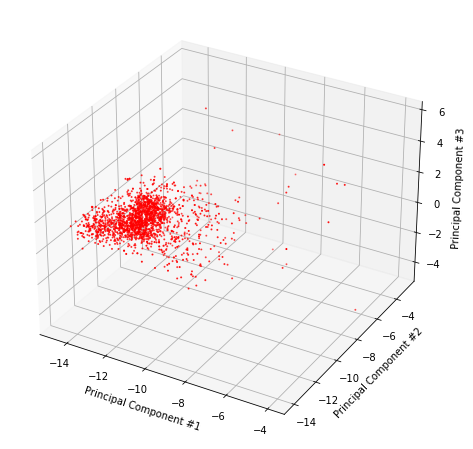

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [4]:
# num_x, num_y, num_z, width_x, width_y, width_z, freq1, freq2, freq3, freq4, freq5, freq6, L2 dist
# [0]    [1]    [2]    [3]      [4]      [5]      [6]    [7]    [8]    [9]    [10]   [11]   [12]

y_cols = [6]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"
# Import the csv file and save as DataFrame
## DATASET 1 ###
filepath = '../data/all_data.csv' 
#filepath = '../data/GSA_1000_datapoints_6freq.csv' # [[3, 10], [3, 10], [3, 10], [5, 10], [5, 10], [5, 10]]  1000no
#filepath = '../data/extreme_30.csv'   # [[1, 30], [1, 30], [1, 50], [0.5, 25], [0.5, 25], [0.5, 25]]  30no
#filepath = '../data/moderate_50.csv'  # [[1, 15], [1, 15], [1, 15], [0.5, 15], [0.5, 15], [0.5, 15]]  50no 
#filepath = '../data/moderate_400.csv'  # [[1, 15], [1, 15], [1, 30], [0.5, 15], [0.5, 15], [0.5, 15]]  400no 
#filepath = '../data/narrowish_300.csv' # [[1, 10], [1, 10], [1, 10], [0.5, 10], [0.5, 10], [0.5, 10]]  300no
#filepath = '../data/slim_200.csv' # [[1, 5], [1, 5], [1, 5], [0.5, 10], [0.5, 10], [0.5, 10]]  200no

df_orig = pd.read_csv(filepath)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

data_mean = df_orig.mean()
data_std = df_orig.std()

# Get PCA components based on UNNORMALISED data
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

# Get PCA transform of NORMALISED data
df_orig_norm = pre.normalise(df_orig, data_mean, data_std)
all_PCA_norm = post.PCA_transformdata(df_orig_norm.iloc[:,x_cols], components=components)
post.PCA_plot(all_PCA_norm, figsize=(8,8), legend=False)

In [5]:
# Define the wandb parameters
parameters = dict(
    # Specific to this method
    drop_prob= 0.5,              # Probablity that a neuron will be switched off
    num_samples=150,              # How many forward passes of the network to make to construct the posterior distribution
    
    # Generic Hyperparameters
    num_epochs= 1500,
    batch_size= 50, # Batch size for training data
    lr=  5e-4,                   # Learning rate
    weight_decay= 0.001,          # Weight decay. 
    
    # Model architecture
    input_dim= len(x_cols),                # Number of input neurons
    output_dim= len(y_cols),               # Number of output neurons
    num_units= 200,              # Number of neurons per hidden layer
    num_layers=3,
    
    # Data
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    
    # Logging only
    component = None,       # Which parameter are we sorting by (as an int)? 
    sortby=None,       # Name of the component we're sorting by (as a string)
    model_name= "MC_Dropout",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only
    cutoff_percentile = None,  # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=None,         # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed                   # Random seed used (for logging only)
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

len(x_train): 929
len(x_test): 945
len(x_val): 104
Total: 1978 of 1978


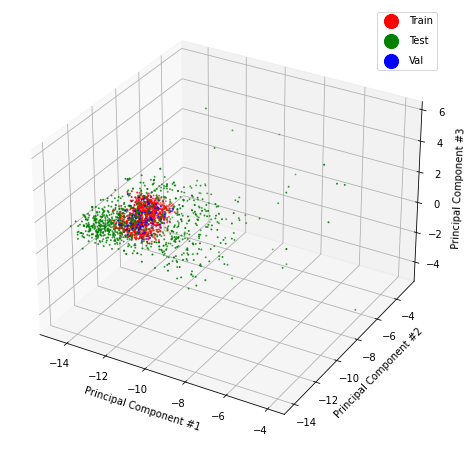

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [6]:
#%matplotlib notebook
# Set out the training boundary
df4, data_mean4, data_std4 = pre.process_df_euclid(df=df_orig.copy(), x_cols=x_cols)

# Define the training domain
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]

## Normalise the training domain
train_lims_all_norm = pre.normalise_lims(train_lims_all, data_mean4[x_cols], data_std4[x_cols])

# Split training and test data using the normalised training domain
df_train, df_test = pre.extract_ood(df4, train_lims_all_norm, test_type="all", verbose=False)

# Reset index in training and test sets. Otherwise breaks later on
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Set up the test dataset etc
x_test_df, y_test_df, x_test, y_test, test_indices, test_data = pre.dataset_from_df(df_test, x_cols, y_cols)

component = 12           # Which column to sort by? This affects the splitting of validation data and visualisation later on
cutoff_percentile = 0.05 # How much to cut off the beginning and end of sorted dataset
val_split = 0.1          # How much to split off for validation (after the OoD/test data has been split off from train)

# Split training from validation data
TRAIN, VAL = pre.split_data(df_train, component=component, y_cols=y_cols, x_cols=x_cols, val_split=val_split, seed=seed, test=False)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL

print(f"len(x_train): {len(x_train)}")
print(f"len(x_test): {len(x_test)}")
print(f"len(x_val): {len(x_val)}")
print(f"Total: {len(x_train) + len(x_test) + len(x_val)} of {len(df_orig)}")

# Get PCA of NORMALISED data, but according to UNNORMALISED PCA components
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], labels=["Train", "Test", "Val"], legend_num=0, figsize=(8,8))

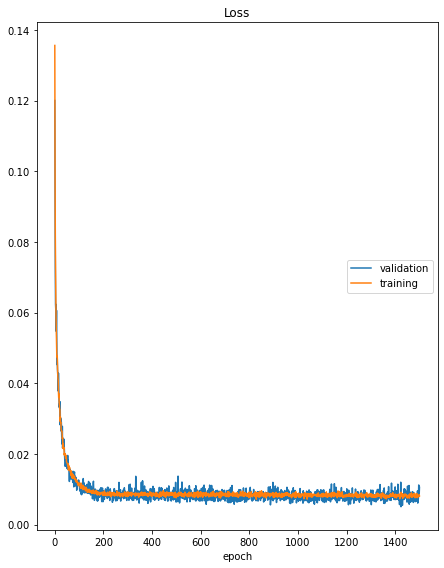

Loss
	validation       	 (min:    0.005, max:    0.120, cur:    0.011)
	training         	 (min:    0.007, max:    0.136, cur:    0.008)
Time elapsed: 140.19s.
Number of trainable model parameters: 41801, number of training samples: 929
Used batches of 50.



In [7]:
model = MC.MC_Dropout(train_data = train_data,parameters=parameters,test_data=test_data,val_data=val_data,data_mean=data_mean,data_std=data_std,wandb_mode=False)
net, train_loss, val_loss = model.train_model(LLP=True)


In [8]:
# For some reason, sometimes the rugplot doesn't work if we are in matplotlib notebook mode!
#%matplotlib inline  


num_samples = np.linspace(1,500,500).astype(int)

X = np.array([[3, 3, 3, 5, 5, 5],      #1
             [7, 7, 7, 7.5, 7.5, 7.5], #2
             [10, 10, 10, 10, 10, 10], #3
             [15, 15, 15, 15, 15, 15], #4
             [30, 30, 30, 25, 25, 25], #5
             [30, 30, 50, 30, 30, 30], #6
             [40, 40, 50, 30, 30, 30], #7
             [1, 1, 1, 1, 1, 1],       #8
             [2, 2, 2, 2, 2, 2],       #9
             [3, 3, 3, 3, 3, 3]])      #10

m = np.zeros((len(num_samples), len(X)))
sd = np.zeros((len(num_samples), len(X)))


for i, samp in enumerate(num_samples):    
    if i%50 == 0: print(i)
    for j, x in enumerate(X):
        _, m[i, j], sd[i, j] = model.make_prediction(x_value = x,
                                     model = model,
                                     data_mean = data_mean,
                                     data_std = data_std,
                                     num_samples=samp)
    

0
50
100
150
200
250
300
350
400
450


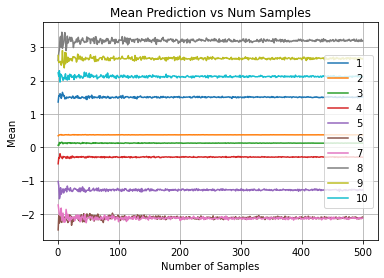

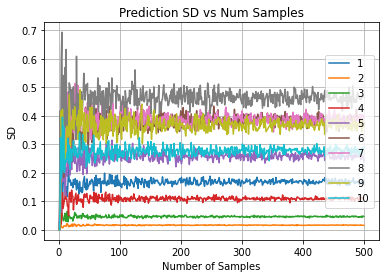

In [9]:
plt.figure()
plt.plot(num_samples, m, label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]);
plt.title("Mean Prediction vs Num Samples");
plt.xlabel("Number of Samples")
plt.ylabel("Mean")
plt.legend(loc="right")
plt.grid()

plt.figure()
plt.plot(num_samples, sd, label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]);
plt.title("Prediction SD vs Num Samples");
plt.xlabel("Number of Samples")
plt.ylabel("SD")
plt.legend(loc="right")
plt.grid()
#print(f"Using X = {x_value}, modal frequency = {m.item():.3f} Hz, +/- {sd.item():.3f} Hz (+/-{100*sd.item()/m.item():.2f}%)")